<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/autoencoder/AutoencoderBasico_Kaggle_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [ ]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
 ! chmod 600 ~/.kaggle/kaggle.json

**Tras relizar algunas configuraciones descargamos el dataset:**

In [ ]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.51G/9.51G [01:27<00:00, 79.8MB/s]
100% 9.51G/9.51G [01:27<00:00, 117MB/s] 
CPU times: user 1.22 s, sys: 212 ms, total: 1.43 s
Wall time: 1min 28s


In [ ]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [ ]:
datasetKaggle = 'datasetKaggle'

In [ ]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [ ]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/99e8bf998285.png'

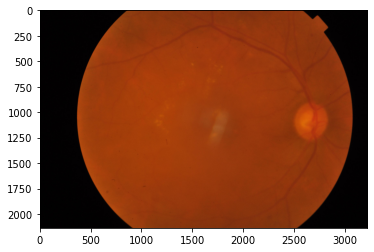

In [ ]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [ ]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [ ]:
df_trainKaggle.head(5)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [ ]:
# !wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
# !wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
# !wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

In [ ]:
# !rm -rvf Training_Set_Pre
# !unzip -qq train.zip #-qq no verbose
# !unzip -qq test.zip
# !unzip -qq val.zip

Descargamos el dataset sin procesar, para aplicar el mismo a los dos datsets

In [ ]:
!wget https://www.dropbox.com/s/1isaa8xrrv0x6n4/datasetComprimido.zip?dl=0 --no-verbose -O datasetComp.zip

2022-06-27 18:22:53 URL:https://uca57e902da6fb6d8c1016e005f6.dl.dropboxusercontent.com/cd/0/inline2/BoBGyxInyiWeZhshA8Glfd0rNe9v4cCIszshnLTdEdG3c9RwtRjhXW1iF73xqU0utcBrHo4jpOTe5yeOQxNDSMAKqHKYAJbIyiikm-MG89YNojSK3oylrRpNIc5a5tdE4kesVeGlZxMzg0a4gu_OHaXm3edUC2TIvCzsuLlYyarXbucCCjP375PoFipXwCagulZMBuRnE0GXmrGguzX5ClJlxQngaQV0YlszKAatmAJNDaZG00PAzGmt_RSw3oSqiGKa0tRtwKubifNFYELDfFvnhkFEABguChS1wdz6X-H4y77mOHjNEnGC_nej5GFA1XM1RYklDYuPVnS_-xMnGW5ZPOaRWuze2VVtfg55_FtsDPESAaJ0elxLXKrk75CHde92ALXi7uaH-ZoLbrXSR8FgREJLZnM8XvYeuAxS0iyRFg/file [144922725/144922725] -> "datasetComp.zip" [1]


In [ ]:
!unzip -qq datasetComp.zip

In [ ]:
# trainPath = 'Training_Set_Pre/'
# testPath  = 'Test_Set_Pre/'
# valPath  =  'Evaluation_Set_Pre/'

In [ ]:
trainPath = 'Training_Set_C/'
testPath  = 'Test_Set_C/'
valPath  =  'Evaluation_Set_C/'

## Preparación de Datos

In [ ]:
IMG_SIZE = 64

### Funciones de procesado

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur(image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

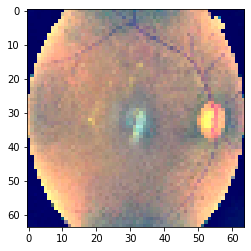

In [ ]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0], 10)
plt.imshow(img)

### Datos Kaggle

In [ ]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    # else:
    #   enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [ ]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [ ]:
normalKaggle.shape

(1805, 64, 64, 3)

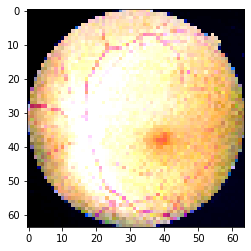

In [ ]:
plt.imshow(normalKaggle[0])

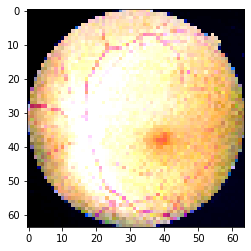

In [ ]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [ ]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = load_ben_color(pathO + '/' + str(id) + '.png', sigmaX=30)
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [ ]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [ ]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [ ]:
normalTrain.shape

(401, 64, 64, 3)

In [ ]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

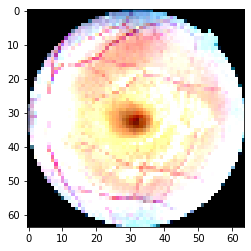

In [ ]:
plt.imshow(normalTrain[0])

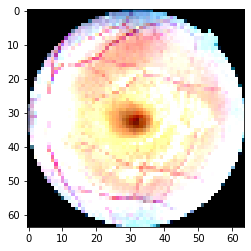

In [ ]:
plt.imshow(normalTrain[0])

In [ ]:
normalTrain = np.concatenate([normalTrain, normalKaggle])

In [ ]:
normalTrain.shape

(2206, 64, 64, 3)

Ahora nos queda normalizar los datos

In [ ]:
normalTrain = normalTrain.astype('float32') / 255.
enfermedadTrain = enfermedadTrain.astype('float32') / 255.

normalVal = normalVal.astype('float32') / 255.
enfermedadVal = enfermedadVal.astype('float32') / 255.

normalTest = normalTest.astype('float32') / 255.
enfermedadTest = enfermedadTest.astype('float32') / 255.

## Autoencoder Basico

In [ ]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [ ]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [ ]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [ ]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 32)        9248

### Entrenamiento

In [ ]:
autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/50
18/18 [==============================] - 1s 44ms/step - loss: 0.5600 - val_loss: 0.4615
Epoch 2/50
18/18 [==============================] - 1s 33ms/step - loss: 0.4464 - val_loss: 0.4082
Epoch 3/50
18/18 [==============================] - 1s 33ms/step - loss: 0.4165 - val_loss: 0.3892
Epoch 4/50
18/18 [==============================] - 1s 33ms/step - loss: 0.4027 - val_loss: 0.3800
Epoch 5/50
18/18 [==============================] - 1s 33ms/step - loss: 0.3963 - val_loss: 0.3769
Epoch 6/50
18/18 [==============================] - 1s 32ms/step - loss: 0.3924 - val_loss: 0.3693
Epoch 7/50
18/18 [==============================] - 1s 33ms/step - loss: 0.3890 - val_loss: 0.3657
Epoch 8/50
18/18 [==============================] - 1s 32ms/step - loss: 0.3873 - val_loss: 0.3636
Epoch 9/50
18/18 [==============================] - 1s 33ms/step - loss: 0.3861 - val_loss: 0.3626
Epoch 10/50
18/18 [==============================] - 1s 33ms/step - loss: 0.3840 - val_loss: 0.3624
Epoch 11/

### Pruebas

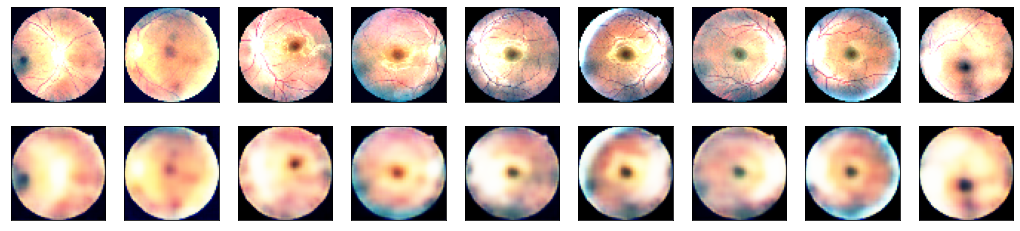

In [ ]:
decoded_imgs = autoencoder.predict(normalTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

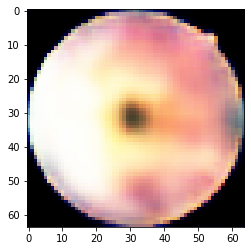

In [ ]:
plt.imshow(decoded_imgs[0])

### Evaluación

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors

def test(autoencoder, data):
  decoded = autoencoder.predict(data)
  errors = []
  for (image, recon) in zip(data, decoded):
    mse = np.mean((image - recon) ** 2)
    errors.append(mse)
  thresh = np.quantile(errors, 0.999)
  idxs = np.where(np.array(errors) >= thresh)[0]
  return len(data)-len(idxs), len(idxs)

In [ ]:
def calcularMetricas(TN, FP, FN ,TP):
  print("Accuracy:  ", ((TP + TN)/(TP + TN + FP + FN)))
  recall = (TP/(TP + FN))
  print("Recall :   ", recall)
  precision = (TP/(TP + FP))
  print("Precisión: ", precision)
  print("F1-Score:  ", (2 * precision * recall)/(precision + recall))

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

Accuracy:   0.209375
Recall :    0.001976284584980237
Precisión:  0.5
F1-Score:   0.003937007874015748


[INFO] mse threshold: 0.009791254345327625
[INFO] 1 outliers found


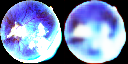

-1

In [ ]:
from google.colab.patches import cv2_imshow

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(enfermedadTest)
errors = []
# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(enfermedadTest, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.999)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))
# initialize the outputs array
outputs = None
# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (enfermedadTest[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output
	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])
# show the output visualization
cv2_imshow(outputs)
cv2.waitKey(0)

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [ ]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(64,64,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

trained_model = autoencoder.fit(
    normalTrain, normalTrain, 
    batch_size=1024, 
    epochs=50, 
    validation_data=(normalVal, normalVal))

Epoch 1/50
3/3 [==============================] - 2s 463ms/step - loss: 0.1185 - val_loss: 0.1102
Epoch 2/50
3/3 [==============================] - 1s 362ms/step - loss: 0.0993 - val_loss: 0.0932
Epoch 3/50
3/3 [==============================] - 1s 359ms/step - loss: 0.0853 - val_loss: 0.0832
Epoch 4/50
3/3 [==============================] - 1s 361ms/step - loss: 0.0781 - val_loss: 0.0779
Epoch 5/50
3/3 [==============================] - 1s 363ms/step - loss: 0.0744 - val_loss: 0.0735
Epoch 6/50
3/3 [==============================] - 1s 364ms/step - loss: 0.0701 - val_loss: 0.0679
Epoch 7/50
3/3 [==============================] - 1s 356ms/step - loss: 0.0637 - val_loss: 0.0613
Epoch 8/50
3/3 [==============================] - 1s 358ms/step - loss: 0.0559 - val_loss: 0.0543
Epoch 9/50
3/3 [==============================] - 1s 360ms/step - loss: 0.0479 - val_loss: 0.0473
Epoch 10/50
3/3 [==============================] - 1s 365ms/step - loss: 0.0403 - val_loss: 0.0403
Epoch 11/50
3/3 [==

In [ ]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

Accuracy:   0.209375
Recall :    0.001976284584980237
Precisión:  0.5
F1-Score:   0.003937007874015748


In [ ]:
predicts = autoencoder.predict(normalTest)

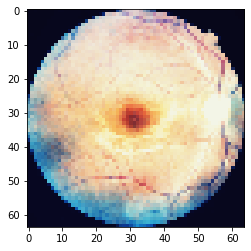

In [ ]:
plt.imshow(predicts[4])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

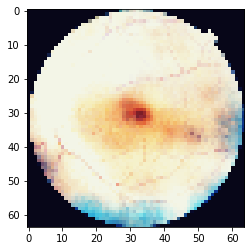

In [ ]:
plt.imshow(predicts[4])

## Otra arquitectura diferente

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [ ]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 64, 64, 32)       128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 32, 32, 64)       256       
 tion)                                                       

In [ ]:
hist=autoencoder.fit(normalTrain, normalTrain,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

Epoch 1/50
18/18 [==============================] - 14s 90ms/step - loss: 0.5647 - val_loss: 0.6329
Epoch 2/50
18/18 [==============================] - 1s 61ms/step - loss: 0.4214 - val_loss: 0.5806
Epoch 3/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3948 - val_loss: 0.5563
Epoch 4/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3852 - val_loss: 0.5462
Epoch 5/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3802 - val_loss: 0.5475
Epoch 6/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3770 - val_loss: 0.5488
Epoch 7/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3746 - val_loss: 0.5416
Epoch 8/50
18/18 [==============================] - 1s 63ms/step - loss: 0.3729 - val_loss: 0.5381
Epoch 9/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3713 - val_loss: 0.5316
Epoch 10/50
18/18 [==============================] - 1s 61ms/step - loss: 0.3701 - val_loss: 0.5178
Epoch 11

In [ ]:
TN, FP = test(autoencoder, normalTest) #TN y FP
FN, TP = test(autoencoder, enfermedadTest) #FN y TP
calcularMetricas(TN, FP, FN ,TP)

Accuracy:   0.209375
Recall :    0.001976284584980237
Precisión:  0.5
F1-Score:   0.003937007874015748


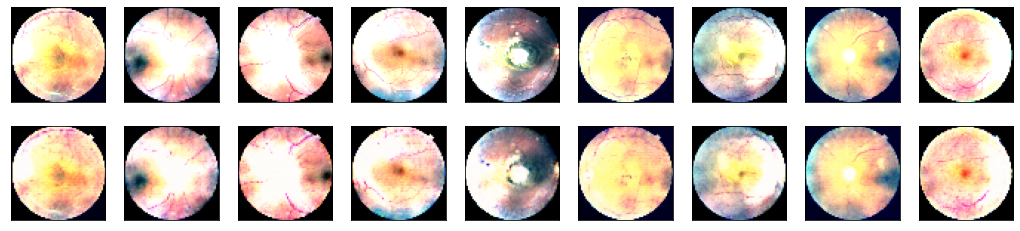

In [ ]:
decoded_imgs = autoencoder.predict(enfermedadTest)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(enfermedadTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
predicts = autoencoder.predict(normalTest)

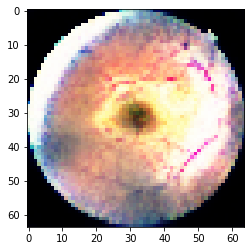

In [ ]:
plt.imshow(predicts[6])

In [ ]:
predicts = autoencoder.predict(enfermedadTest)

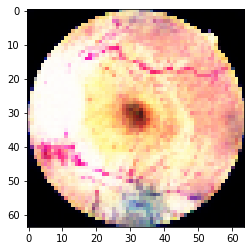

In [ ]:
plt.imshow(predicts[70])

## Otra alternativa

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

In [ ]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)